In [191]:
from qutip import basis, sigmax, sigmaz, sigmay, Options 
from qutip.solver.heom import DrudeLorentzBath
from qutip.solver.heom import HEOMSolver
from qutip.solver.heom import DrudeLorentzPadeBath
from qutip.solver.heom import BathExponent
import math
__all__ = ['parallel_map', 'serial_map', 'loky_pmap', 'mpi_pmap']

import multiprocessing
import os
import sys
import time
import threading
import concurrent.futures
import warnings
from qutip.ui.progressbar import progress_bars
from qutip.settings import available_cpu_count
from scipy.fft import fft, ifft 
from scipy.special import shichi
from mpmath import meijerg
import scipy
import matplotlib.pyplot as plt
import qutip

import numpy as np 
import time 




# More flexibel solver for custom bath
from qutip.solver.heom import HSolverDL
from qutip.solver.heom import BosonicBath

import qutip.solver.brmesolve as brmesolve

In [192]:
"""Define Constants"""
#hbar, kb=1
we=1 # With hbar = 1 this is the upper energy
wg=0# ground state
ve=0.1 #  ground state frequencie from the exited atomic state in 0.1*we 
vg=0.1 # ground state frequencie from the ground atomic state 
λ1=0.5# dim less coupling constant depending on the shift of the energy minima shifts in space
g1=0.1 #couplig to the atom to the bath   
g2=0.1 #couplig to the vibronic modes to the bath 
tlist = np.linspace(0,80, 1000) # 40 times atomic frequencie 4 times vibronic
#### ground parameters
λ2=vg**2-ve**2/4*vg**2 # dim less coupling constant depending on the vibronic freq 
w0=we- wg + λ1**2 *vg**3 /ve**2
w00 = we - wg + (ve - vg )/2

gamma_1=0.1
gamma_2=0.1
beta=10 #temp Einheit von  hb*omega durch kb
A=-λ1/(1+4*λ2)
rs=2*(2*np.pi*1J+np.log(1+4*λ2)**0.25)
rs=1/4*(np.log(ve**2/vg**2))
#nb=1/(np.exp((w) * beta)-1)
def nb(w):
    return np.float128(1/(np.exp((w) * beta)-1))
N=30# size of the vibronic hilbi space 
#tlist=np.linspace[0,1,10]
# operators
b  = qutip.tensor(qutip.qeye(2),qutip.destroy(N)) #ladder operator of the vibronic modes 
P12 = qutip.tensor(basis(2,0)*basis(2,1).dag(),qutip.qeye(N))
P21 = qutip.tensor(basis(2,1)*basis(2,0).dag(),qutip.qeye(N))
P11 = qutip.tensor(basis(2,0)*basis(2,0).dag(),qutip.qeye(N))
P22 = qutip.tensor(basis(2,1)*basis(2,1).dag(),qutip.qeye(N))
psi0 = qutip.tensor(basis(2,1),basis(N,0))   #|e,0>
rho0=qutip.tensor(basis(2,1)*basis(2,1).dag(),basis(N,0)*basis(N,0).dag()) #|e,0><e,0|


#System hamiltonian
H= vg*b.dag()*b +w0*P21*P12 + λ1*vg*(b+b.dag())*P21*P12+λ2*vg*(b+b.dag())**2  *P21*P12     
    
H_diag=vg*P12*P21*b.dag()*b+ (vg*b.dag()*b+w00)*P21*P12
# H_int 
O1=P12+P21
O2=b+b.dag()
wc = 10.0      # Cutoff-Frequenz ω_c
g = 0.1        # Kopplungskonstante

# Berechnung der Lamb-Shift-Funktion
def gamma(wx, wc, g):
    term1 = scipy.special.gammainc(0, -wx / wc)  # Gamma[0, -w0/wc]
    term2 = -np.log(-wx)
    term3 = np.log(-wx / wc)
    term4 = np.log(wc)
    
    prefactor = g / (np.pi * wc)
    bracket = (wc + wx * np.exp(w0 / wc)) * (term1 + term2 + term3 + term4)
    
    return float(prefactor * bracket.real())
evals , ekets = H.eigenstates()
evals2 , ekets2 = H_diag.eigenstates()
print(H_diag)
#print(ekets,ekets2)
state1=qutip.tensor( basis(2,1),qutip.basis(N,0))
state2=qutip.tensor(basis(2,0),qutip.basis(N,1))
#print(state1.dag()*H_diag*state2)
def SS(H):
    return (-H*beta).expm()/((-H*beta).expm().tr())
print((SS(H)*P22).tr())
print((SS(H_diag)*P22).tr())
"""wc = 10.0      # Cutoff-Frequenz ω_c
g = 0.1        # Kopplungskonstante

# Berechnung der Lamb-Shift-Funktion
def lamb_shift(w0, wc, g):
    term1 = gammainc(0, -w0 / wc, regularized=False)  # Gamma[0, -w0/wc]
    term2 = -log(-w0)
    term3 = log(-w0 / wc)
    term4 = log(wc)
    
    prefactor = g / (pi * wc)
    bracket = (wc + w0 * exp(w0 / wc)) * (term1 + term2 + term3 + term4)
    
    return float(prefactor * bracket)"""


Quantum object: dims=[[2, 30], [2, 30]], shape=(60, 60), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.1 0.  ... 0.  0.  0. ]
 [0.  0.  0.2 ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 3.7 0.  0. ]
 [0.  0.  0.  ... 0.  3.8 0. ]
 [0.  0.  0.  ... 0.  0.  3.9]]
4.4021452921627196e-05
4.539786870243438e-05


'wc = 10.0      # Cutoff-Frequenz ω_c\ng = 0.1        # Kopplungskonstante\n\n# Berechnung der Lamb-Shift-Funktion\ndef lamb_shift(w0, wc, g):\n    term1 = gammainc(0, -w0 / wc, regularized=False)  # Gamma[0, -w0/wc]\n    term2 = -log(-w0)\n    term3 = log(-w0 / wc)\n    term4 = log(wc)\n    \n    prefactor = g / (pi * wc)\n    bracket = (wc + w0 * exp(w0 / wc)) * (term1 + term2 + term3 + term4)\n    \n    return float(prefactor * bracket)'

In [193]:


# Displacement und Squeezing im Oszillatorraum
D_op = qutip.displace(N, A)
#S_op = qutip.squeeze(N, rs)
D_op= qutip.tensor(qutip.qeye(2), D_op )
#S_op = qutip.tensor(qutip.qeye(2),  S_op)
S_op = qutip.squeezing(b,b, rs)

U = P12*P21 +(D_op * S_op*P21*P12)
# Transformation auf sigma
P12r = U.dag() * P12 * U
P21r = U.dag() * P21 * U
print(P12,P12r,D_op*S_op*P12)
U1 = P12*P21 +D_op *P21*P12
U2 = P12*P21 +S_op *P21*P12
#U=U1*U2
br=U.dag() *b * U
br2= b* P12*P21  +(b *np.cosh(rs)  - b.dag()*np.sinh(rs)+A*np.cosh(rs))*P21*P12
be = (np.cosh( rs) *b + np.sinh( rs)* b.dag() - 1/2*A* np.exp(rs) )*P21*P12

print(br,br2,be)
print(U.dag() *H *U)
c=b* P12*P21  +(b *np.cosh(rs)  - b*np.sinh(rs))*P21*P12
P12r=D_op*S_op*P12
P21r=P12r.dag()

Quantum object: dims=[[2, 30], [2, 30]], shape=(60, 60), type='oper', dtype=Dense, isherm=False
Qobj data =
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] Quantum object: dims=[[2, 30], [2, 30]], shape=(60, 60), type='oper', dtype=Dense, isherm=False
Qobj data =
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.21169590e-23
  2.00956113e-24 1.80772735e-25]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.23133492e-21
  1.16058456e-22 1.08218179e-23]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.66478588e-20
  4.56744610e-21 4.42065258e-22]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]] Quantum object: dims=[[2, 30

In [ ]:
# decay 

########################################################################################################
gamma_1=0.1
gamma_2=0.1
c_op_list=[]
print("do",gamma_1)
c_op_list.append(np.sqrt((nb(w0)+1)*gamma_1)*P12)
c_op_list.append(np.sqrt((nb(w0))*gamma_1)*P21)
c_op_list.append(np.sqrt((nb(vg)+1)*gamma_2)*b*P11)
c_op_list.append(np.sqrt((nb(vg))*gamma_2)*b.dag()*P11)
c_op_list.append(np.sqrt((nb(ve)+1)*gamma_2)*b*P22)
c_op_list.append(np.sqrt((nb(ve))*gamma_2)*b.dag()*P22)
Resul_Lindblad=qutip.mesolve(H, psi0, tlist, [c_op_list], [P22, P11,P12,b.dag()*b*P22,b.dag()*b*P11])

fig, ax = plt.subplots()
ax.plot(tlist, Resul_Lindblad.expect[0])
ax.plot(tlist, Resul_Lindblad.expect[1])
ax.plot(tlist, Resul_Lindblad.expect[2])
ax.plot(tlist, Resul_Lindblad.expect[3])
ax.plot(tlist, Resul_Lindblad.expect[4])
ax.set_xlabel('t x 1/w_eg')
ax.set_ylabel('Expectation values')
ax.legend(("Pe", "Pg","P12","N * P22 ","N * P11"))
ax.axhline(y=(SS(H)*P22).tr(), xmin=0, xmax=40, color='r', linestyle='--')
ax.axhline(y=1/(np.exp(100)-1), xmin=0, xmax=40, color='b', linestyle='--')
plt.show()

do 0.1


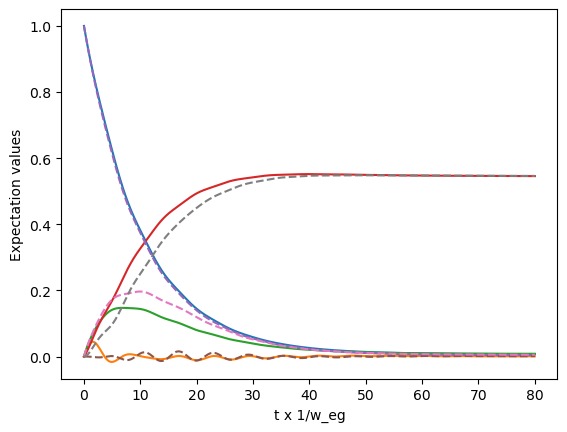

Quantum object: dims=[[2, 30], [2, 30]], shape=(60, 60), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 1.00000000e+00 -5.01504919e-17  9.36824210e-17 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-5.01504919e-17  1.00000000e+00  3.83205850e-17 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 9.36824210e-17  3.83205850e-17  1.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]] Quantum object: dims=[[2, 30], [2, 30]], shape=(60, 60), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0.

In [ ]:
gamma_1_diag=0.1
gamma_2_diag=0.1
c_op_list_diag=[]

c_op_list_diag.append(np.sqrt((nb(w00)+1)*gamma_1_diag)*P12r)
c_op_list_diag.append(np.sqrt((nb(w00))*gamma_1_diag)*P21r)
c_op_list_diag.append(np.sqrt((nb(vg)+1)*gamma_2_diag)*c*P12r*P21r)
c_op_list_diag.append(np.sqrt((nb(vg))*gamma_2_diag)*c.dag()*P12r*P21r)
c_op_list_diag.append(np.sqrt((nb(ve)+1)*gamma_2_diag)*c*P21r*P12r)
c_op_list_diag.append(np.sqrt((nb(ve))*gamma_2_diag)*c.dag()*P21r*P12r)


c_op_list_diag.append(np.sqrt((nb(w00)+1)*gamma_2_diag)*A *np.cosh(rs)*(P21*P12+P12*P21))
c_op_list_diag.append(np.sqrt((nb(w00))*gamma_2_diag)*A *np.cosh(rs)*(P21*P12+P12*P21))
Resul_Lindblad_diag=qutip.mesolve(H_diag, psi0, tlist, [c_op_list_diag], [P21r*P12r, P12*P21,P12r,b.dag()*b*P21*P12,b.dag()*b*P12*P21])


fig, ax = plt.subplots()
ax.plot(tlist, Resul_Lindblad_diag.expect[0])
#ax.plot(tlist, Resul_Lindblad_diag.expect[1])
ax.plot(tlist, Resul_Lindblad_diag.expect[2])
ax.plot(tlist, Resul_Lindblad_diag.expect[3])
ax.plot(tlist, Resul_Lindblad_diag.expect[4])

ax.plot(tlist, Resul_Lindblad.expect[0],linestyle="--")
#ax.plot(tlist, Resul_Lindblad.expect[1],linestyle="--")
ax.plot(tlist, Resul_Lindblad.expect[2],linestyle="--")
ax.plot(tlist, Resul_Lindblad.expect[3],linestyle="--")
ax.plot(tlist, Resul_Lindblad.expect[4],linestyle="--")

ax.set_xlabel('t x 1/w_eg')
ax.set_ylabel('Expectation values')
#x.legend(("Pe", "Pg","P12","N * P22 ","N * P11"))
#ax.axhline(y=(SS(H)*P22).tr(), xmin=0, xmax=40, color='r', linestyle='--')
#ax.axhline(y=1/(np.exp(100)-1), xmin=0, xmax=40, color='b', linestyle='--')
plt.show()
print(P12r*P21r,P12*P21,P21*P12+P12*P21)